# Feature Engineering

---

## 1. Introduction

- Explain the purpose of this notebook.
- Briefly list the new features you plan to create.

## 2. Loading and Preparing Data

In [106]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
import sys
import os

# Assuming 'scripts' is in the same parent directory as 'notebooks'
sys.path.append(os.path.abspath("../scripts"))

from feature_engineering import create_features

In [108]:
# Load the cleaned data
logistics_df = pd.read_csv('../data/raw/logistics_df.csv')
logistics_df.head()

,Route ID,Driver ID,Delivery Time (hours),Date,Fuel Costs (USD),Delivery Start Time,Distance Traveled (miles),Estimated Distance (miles),Weather Conditions,Traffic Conditions,...,Cost per Gallon (USD),Total Fuel Cost (USD),Insurance Costs (USD),Breakdown Repair Costs (USD),Overtime Labor Costs (USD),Fuel Surcharge (USD),Idle Cost (USD),Total Operational Cost (USD),Fuel Cost per Mile,Delivery Efficiency Score
0,c405a09a-7c1c-4cbb-b044-8d93ec12fd41,cd5f2588-0177-4ecf-b43b-64e4cffdae77,3.661775,2023-04-24,73.167465,18:11:58,1453.290310,1284.660045,Snow,Moderate,...,3.5,612.042183,82.188272,658.105936,0.000000,7.739251,1.197690,854.695690,0.050346,0.035347
1,1fedfb9c-4dd4-4866-ba9b-249b6c28a57c,cef901ab-9579-4d33-8a47-f2d772f71c72,9.159558,2023-08-08,639.179375,00:56:12,751.259132,2132.837081,Snow,Moderate,...,3.0,271.188926,31.393083,699.534174,29.666102,67.608867,0.909051,1531.803244,0.850811,0.006516
2,5870f02e-e6c5-47a2-b17c-2d9eb0a6b371,0ee00c87-6ef8-4895-b25a-ef185b8f1555,1.372942,2023-08-22,92.633480,02:29:03,2666.204691,2661.824609,Light Rain,Light,...,3.5,1122.851867,54.905655,999.656631,0.000000,9.798258,2.693096,1178.100685,0.034744,0.060085
3,7d4a8625-bd3a-42e8-ba14-1770b143f82d,49a5eacb-02d2-408b-b79d-9d3f447d2e37,3.855411,2023-08-24,538.893607,21:07:08,1220.239053,691.805233,Snow,Severe,...,3.0,440.480927,39.639937,825.812869,0.000000,57.001192,2.442666,1495.349013,0.441630,0.047148
4,a4f49219-8ed9-49cd-a20e-6f82cc0e9554,b3ae425a-f6f9-41c6-ac70-672e7a7e5bcf,2.194644,2023-08-10,810.358195,11:36:06,2686.870337,2337.833994,Heavy Rain,Heavy,...,3.5,1131.555047,39.600330,769.116645,0.000000,85.715218,2.511495,1727.060317,0.301599,0.017343


In [109]:
# Create Cost per Mile
logistics_df['Cost per Mile'] = logistics_df['Fuel Costs (USD)'] / logistics_df['Distance Traveled (miles)']


In [110]:
logistics_df['Cost per Ton-Mile'] = logistics_df['Total Operational Cost (USD)'] / (logistics_df['Load Weight (tons)'] * logistics_df['Distance Traveled (miles)'])

In [111]:
# Create Delivery Efficiency feature
logistics_df['Delivery Efficiency'] = logistics_df['Distance Traveled (miles)'] / logistics_df['Delivery Time (hours)']


In [112]:
# Map Customer Satisfaction to numeric values (assuming an ordinal scale)
satisfaction_map = {
    'Very Dissatisfied': 1,
    'Dissatisfied': 2,
    'Neutral': 3,
    'Satisfied': 4,
    'Very Satisfied': 5
}

# Apply the mapping
logistics_df['Customer Satisfaction'] = logistics_df['Customer Satisfaction'].map(satisfaction_map)

inefficient_routes = logistics_df[
    (logistics_df['Fuel Cost per Mile'] > logistics_df['Fuel Cost per Mile'].quantile(0.75)) |
    (logistics_df['Delays (hours)'] > logistics_df['Delays (hours)'].quantile(0.75)) |
    (logistics_df['Customer Satisfaction'] < 3)]

Traffic Conditions:
        
Purpose: Helps analyze how traffic impacts delivery time and fuel consumption, allowing you to recommend optimal delivery times or routes.


In [113]:
 # Categorize routes by length
conditions = [
    (logistics_df['Distance Traveled (miles)'] < 100),
    (logistics_df['Distance Traveled (miles)'] >= 100) & (logistics_df['Distance Traveled (miles)'] < 300),
    (logistics_df['Distance Traveled (miles)'] >= 300)
    ]
categories = ['Short', 'Medium', 'Long']
logistics_df['Route Length'] = np.select(conditions, categories)

    # Map weather conditions to severity levels
weather_map = {
    'Sunny': 'Low',
    'Cloudy': 'Low',
    'Windy': 'Moderate',
    'Rainy': 'High',
    'Snowy': 'High',
    'Stormy': 'Severe'
    }
logistics_df['Weather Severity'] = logistics_df['Weather Conditions'].map(weather_map)


In [114]:
weather_map = {'Sunny': 1, 'Cloudy': 2, 'Windy': 3, 'Rainy': 4, 'Snowy': 5, 'Stormy': 6}
logistics_df['Weather Severity Score'] = logistics_df['Weather Conditions'].map(weather_map)

In [115]:
logistics_df['Severe Weather'] = logistics_df['Weather Conditions'].apply(lambda x: 1 if x in ['Rainy', 'Snowy', 'Stormy'] else 0)

In [116]:
severity_mapping = {'Clear': 0, 'Light Rain': 1, 'Heavy Rain': 2, 'Snow': 3, 'Fog': 2}  # Example severity scores
logistics_df['Weather Severity Index'] = logistics_df['Weather Conditions'].map(severity_mapping)

In [117]:
inefficient_routes = logistics_df[(logistics_df['Fuel Cost per Mile'] > logistics_df['Fuel Cost per Mile'].quantile(0.75)) |
                               (logistics_df['Delays (hours)'] > logistics_df['Delays (hours)'].quantile(0.75)) |
                               (logistics_df['Customer Satisfaction'] < 3)]

In [118]:
route_delivery_time = logistics_df.groupby('Route ID')['Delivery Time (hours)'].mean()

In [119]:
logistics_df['Fuel Cost per Mile'] = logistics_df['Fuel Costs (USD)'] / logistics_df['Distance Traveled (miles)']

In [120]:
logistics_df['Performance Score'] = (1 / (1 + logistics_df['Delays (hours)']) * logistics_df['Customer Satisfaction'] * (1 / (1 + logistics_df['Fuel Cost per Mile'])))

In [121]:
logistics_df['Driver Consistency Score'] = logistics_df.groupby('Driver ID')['Delays (hours)'].transform('mean')

In [122]:
# Calculate Fuel Cost per Mile
logistics_df['Fuel Cost per Mile'] = logistics_df['Fuel Costs (USD)'] / logistics_df['Distance Traveled (miles)']


In [123]:
logistics_df = pd.get_dummies(logistics_df, columns=['Traffic Conditions'], drop_first=False)

In [124]:
# Add a binary target variable for On-Time Delivery
logistics_df['On-Time Delivery'] = np.where(logistics_df['Delays (hours)'] > 1, 0, 1)  # 1 = On-Time, 0 = Delayed

New Features for Driver Experience and Weather Severity
a) Driver Experience on Specific Routes

Assign numeric values based on driver experience to analyze its impact on long and challenging routes.

In [125]:
# Map driver experience to numeric values
experience_map = {'Junior': 1, 'Intermediate': 2, 'Senior': 3}
logistics_df['Driver Experience Level'] = logistics_df['Driver Experience'].map(experience_map)

# Interaction term: experienced drivers on long routes
logistics_df['Experience on Long Routes'] = logistics_df['Driver Experience Level'] * (logistics_df['Route Length'] == 'Long').astype(int)

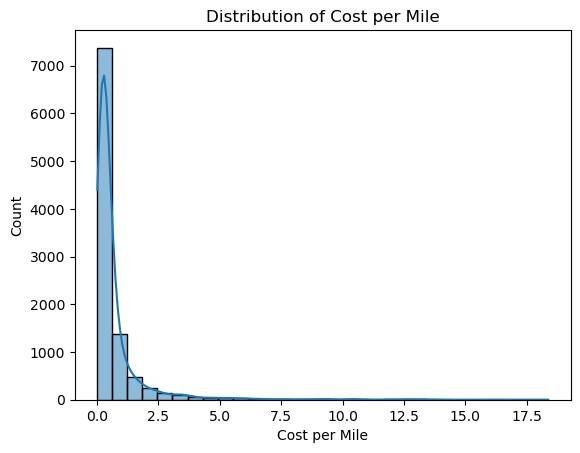

In [126]:
sns.histplot(logistics_df['Cost per Mile'], bins=30, kde=True)
plt.title("Distribution of Cost per Mile")
plt.show()


In [127]:
# Save the engineered data
logistics_df.to_csv('../data/processed/engineered_data.csv', index=False)



Enhanced Modeling
a) Improved Feature Engineering for Regression Model

Add interaction terms and apply hyperparameter tuning for better performance.

In [128]:
# Interaction term: Distance and Truck Condition
logistics_df['Distance * Truck Condition'] = logistics_df['Distance Traveled (miles)'] * logistics_df['Truck Condition']

# Define features and target
X = logistics_df[['Distance Traveled (miles)', 'Truck Condition', 'Driver Ratings', 'Load Weight (tons)', 
                  'Traffic Conditions_Severe', 'Weather Severity Index', 'Distance * Truck Condition']]
y = logistics_df['Total Operational Cost (USD)']

# Hyperparameter tuning with GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best RMSE: 342.78564113084934
